In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import torchvision  # load datasets
from torch.utils.data import DataLoader
from models import SimpleCNN, MoreComplex, Net
from dataloader import BirdDataset
import os
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt  # for plotting

In [17]:
# In your Jupyter Notebook
%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()


# Set environment variable for more accurate CUDA error messages
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper Functions


In [18]:
def imshow(img):
    """function to show image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Setup


In [19]:
# Check if GPU is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu")
print(torch.cuda.memory_allocated(device=device))

# Create the model instance and move it to the device (GPU/CPU)
model = SimpleCNN().to(device)

model1 = MoreComplex().to(device)

net = Net().to(device)

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# Define transformations
transform = transforms.Compose(
    [
        transforms.Resize((400, 360)),  # Resize the image to 467x385
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Initialize the train dataset and dataloader
train_dataset = BirdDataset(csv_file="train_images.csv", transform=transform)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Initialize the test dataset and dataloader
test_dataset = BirdDataset(csv_file="test_images_path.csv", transform=transform)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

0


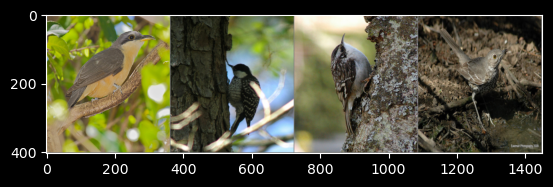

In [22]:
for image, label in train_loader:
    # print(image)
    # break
    imshow(torchvision.utils.make_grid(image))
    break

#         break
# # # get random training images with iter function
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # call function on our images
# imshow(torchvision.utils.make_grid(images))

# # print the class of the image
print(" ".join("%s" % classes[labels[j]] for j in range(batch_size)))

# Model #1


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # or any other appropriate number of epochs
for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for image, label in tepoch:
            images, labels = image.to(device), label.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)
            # Backward and optimize
            optimizer.zero_grad()

            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            # loss = F.nll_loss(output, labels)
            correct = (predictions == labels).sum().item()
            accuracy = correct / train_loader.batch_size

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item(), accuracy=100.0 * accuracy)

            # print(f"Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}]")

# Model 2


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Finished Training")
print(start.elapsed_time(end))  # milliseconds